# Analyseprojekt: Immobilienpreisvorhersage Milwaukee

## Datenquelle: Milwaukee Open Data - Property Sales: https://data.milwaukee.gov/dataset/property-sales-data

## 1. INITIALISIERUNG & KONFIGURATION

In [1]:
# Forschungsfrage explizit definieren
RESEARCH_QUESTION = "Wie können Machine-Learning-Modelle unter Verwendung von Milwaukee Property Sales Data den Verkaufspreis von Immobilien mit einer Genauigkeit von mindestens 70% R² vorhersagen, und welche Faktoren haben den größten Einfluss auf den Immobilienpreis?"
BUSINESS_CONTEXT = "Automatisierte Preisvorhersagen für Immobilienplattformen, Bankenbewertungen und Investmententscheidungen"

print(f"FORSCHUNGSFRAGE: {RESEARCH_QUESTION}")
print(f"GESCHÄFTSKONTEXT: {BUSINESS_CONTEXT}")

FORSCHUNGSFRAGE: Wie können Machine-Learning-Modelle unter Verwendung von Milwaukee Property Sales Data den Verkaufspreis von Immobilien mit einer Genauigkeit von mindestens 70% R² vorhersagen, und welche Faktoren haben den größten Einfluss auf den Immobilienpreis?
GESCHÄFTSKONTEXT: Automatisierte Preisvorhersagen für Immobilienplattformen, Bankenbewertungen und Investmententscheidungen


In [2]:
# Hier werden alle notwendigen Bibliotheken für Datenanalyse, Visualisierung und Machine Learning importiert und konfiguriert.
import os
import csv
import json
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import numpy as np
import pandas as pd

# Visualisierung
import matplotlib.pyplot as plt
import seaborn as sns

# Statistik
from scipy import stats

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.utils import resample

# Modelle
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
import xgboost as xgb

# Metriken
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Modell-Speicherung
import joblib

# Konfiguration
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Plot-Styling
plt.style.use("default")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
sns.set_palette("husl")


print("Erfolgreich")

Erfolgreich


# 2. DATENEXPLORATION UND QUALITÄTSANALYSE

## 2.1 Datensatz laden

In [3]:
# Wenn Path nicht automatisch erkannt wird, fügen Sie bitte hier den eigenen Pfad zum Input-Ordner ein (1x Datensatz).
# try:
#   dataset = pd.read_csv("/Users/tb/Desktop/ADS_02-Talab-Borto/input/2002-2025-property-sales-data.csv")
# except:
#   dataset = pd.read_csv("/Users/tb/Desktop/ADS_02-Talab-Borto/input/2002-2025-property-sales-data.csv", sep=';') 

base_dir = os.path.abspath(os.path.join(os.path.dirname(__file__), "..")) if "__file__" in locals() else os.path.abspath("..")
DATA_PATH = os.path.join(base_dir, "input", "2002-2025-property-sales-data.csv")

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Datei nicht gefunden: {DATA_PATH}")

try:
    dataset = pd.read_csv(DATA_PATH, encoding="utf-8")
except pd.errors.ParserError:
    dataset = pd.read_csv(DATA_PATH, sep=";", encoding="utf-8")

print(f"{dataset.shape[0]} Zeilen, {dataset.shape[1]} Spalten")

74026 Zeilen, 20 Spalten


## 2.2 Erster Blick auf die vorhandenen Daten

In [4]:
#Erster Blick auf die vorhandenen Daten
dataset.head() 

,PropertyID,PropType,taxkey,Address,CondoProject,District,nbhd,Style,Extwall,Stories,Year_Built,Rooms,FinishedSqft,Units,Bdrms,Fbath,Hbath,Lotsize,Sale_date,Sale_price
0,1.0,Commercial,3.230461e+09,2628 N 6TH ST,NaN,6.0,6258.0,Commercial Exempt,NaN,2.0,1880.0,0.0,1840.0,1.0,0.0,0.0,0.0,12750.0,2002-01-01,15900.0
1,2.0,Commercial,3.590192e+09,1363 N PROSPECT AV,NaN,3.0,6262.0,Mansions With Commercial Usage,NaN,2.0,1876.0,0.0,6377.0,1.0,0.0,0.0,0.0,11840.0,2002-01-01,850000.0
2,3.0,Commercial,4.161194e+09,617 S 94TH ST,NaN,10.0,6272.0,Service Building,NaN,1.0,1954.0,0.0,5022.0,1.0,0.0,0.0,0.0,9700.0,2002-01-01,119000.0
3,4.0,Commercial,1.719836e+09,3624 W SILVER SPRING DR,NaN,1.0,6218.0,"Store Bldg - Multi Story (Store & Apt, Store & O",NaN,2.0,1955.0,0.0,6420.0,1.0,0.0,0.0,0.0,8792.0,2002-01-01,210000.0
4,5.0,Commercial,3.480290e+09,3830 W LISBON AV,NaN,15.0,6254.0,"Store Bldg - Multi Story (Store & Apt, Store & O",NaN,2.0,1909.0,0.0,5956.0,1.0,0.0,0.0,0.0,4840.0,2002-01-01,48500.0


## 2.3 Übersicht über Spalteninformationen und Datentypen

In [5]:
#Informationen zu den Spalten und Datentypen 
dataset.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74026 entries, 0 to 74025
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PropertyID    74024 non-null  float64
 1   PropType      74013 non-null  object 
 2   taxkey        74024 non-null  float64
 3   Address       74020 non-null  object 
 4   CondoProject  11956 non-null  object 
 5   District      74022 non-null  float64
 6   nbhd          73967 non-null  float64
 7   Style         73916 non-null  object 
 8   Extwall       58611 non-null  object 
 9   Stories       73822 non-null  float64
 10  Year_Built    73955 non-null  float64
 11  Rooms         71978 non-null  float64
 12  FinishedSqft  73907 non-null  float64
 13  Units         74024 non-null  float64
 14  Bdrms         71979 non-null  float64
 15  Fbath         73369 non-null  float64
 16  Hbath         69184 non-null  float64
 17  Lotsize       74023 non-null  float64
 18  Sale_date     74024 non-nu

## 2.4 Statistische Übersicht der numerischen Merkmale

In [6]:
#Statistische Übersicht der numerischen Spalten
dataset.describe() 

,PropertyID,taxkey,District,nbhd,Stories,Year_Built,Rooms,FinishedSqft,Units,Bdrms,Fbath,Hbath,Lotsize,Sale_price
count,74024.000000,7.402400e+04,74022.000000,73967.000000,73822.000000,73955.000000,71978.000000,73907.000000,74024.000000,71979.000000,73369.000000,69184.000000,7.402300e+04,7.401400e+04
mean,222534.124027,3.609154e+09,7.971630,3598.025457,1.419279,1926.561395,3.866042,2367.845049,1.521034,3.131386,1.372542,0.314943,3.608085e+04,2.470618e+05
std,304544.613970,1.492403e+09,4.212972,1836.207961,0.654477,185.230555,4.067819,8329.596260,7.875536,7.729959,0.718298,0.512378,6.481416e+06,1.092199e+06
min,1.000000,1.001100e+07,1.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,18506.750000,2.610907e+09,4.000000,2040.000000,1.000000,1923.000000,0.000000,1066.000000,1.000000,2.000000,1.000000,0.000000,3.600000e+03,1.076375e+05
50%,113057.500000,3.530500e+09,8.000000,4100.000000,1.000000,1950.000000,4.000000,1360.000000,1.000000,3.000000,1.000000,0.000000,5.040000e+03,1.589000e+05
75%,228181.250000,5.000128e+09,11.000000,4910.000000,2.000000,1959.000000,6.000000,1964.000000,1.000000,4.000000,2.000000,1.000000,6.960000e+03,2.340000e+05
max,881476.000000,7.169999e+09,15.000000,46113.000000,40.000000,2024.000000,70.000000,378717.000000,781.000000,2031.000000,10.000000,10.000000,1.703065e+09,1.246000e+08


## 2.5 Fehlende Werte Analyse

Fehlende Werte pro Spalte (%):
CondoProject    83.85
Extwall         20.82
Hbath            6.54
Rooms            2.77
Bdrms            2.77
Fbath            0.89
Stories          0.28
FinishedSqft     0.16
Style            0.15
Year_Built       0.10
nbhd             0.08
Sale_price       0.02
PropType         0.02
District         0.01
Address          0.01
Units            0.00
taxkey           0.00
Lotsize          0.00
Sale_date        0.00
PropertyID       0.00
dtype: float64


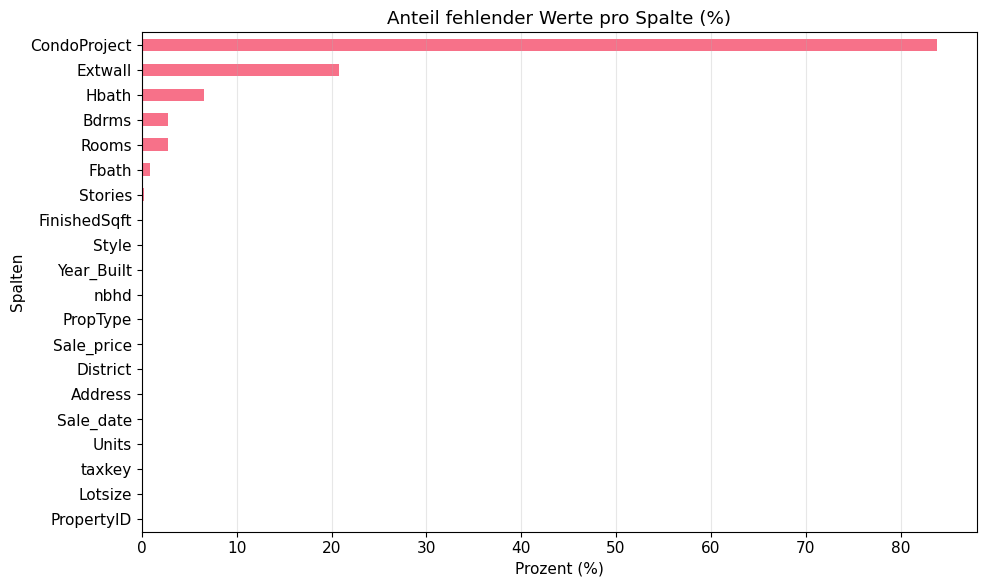

In [7]:
# Prozentualer Anteil fehlender Werte
missing_pct = (dataset.isna().sum() / len(dataset) * 100).round(2)
print("Fehlende Werte pro Spalte (%):")
print(missing_pct.sort_values(ascending=False))

# Visualisierung der fehlenden Werte
plt.figure(figsize=(10, 6))
missing_pct.sort_values(ascending=True).plot(kind='barh')
plt.title("Anteil fehlender Werte pro Spalte (%)")
plt.xlabel("Prozent (%)")
plt.ylabel("Spalten")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 2.6 Kritische Datenqualitätsanalyse

In [8]:
def analyze_data_quality(df):
    """Umfassende Datenqualitätsanalyse mit kritischer Diskussion"""
    quality_report = {}
    
    # Problematische Nullwerte identifizieren
    zero_values = {
        'Year_Built_0': (df['Year_Built'] == 0).sum(),
        'FinishedSqft_0': (df['FinishedSqft'] == 0).sum(),
        'Rooms_0': (df['Rooms'] == 0).sum(),
        'Sale_price_0': (df['Sale_price'] == 0).sum()
    }
    
    # Plausibilitätschecks
    implausible_age = (df['Year_Built'] > 2025).sum()
    implausible_sqft = (df['FinishedSqft'] > 10000).sum()
    implausible_price = (df['Sale_price'] > 5000000).sum()
    
    print("🔍 KRITISCHE DATENQUALITÄTSANALYSE:")
    print(f"• Ungültige Baujahre (0): {zero_values['Year_Built_0']} ({zero_values['Year_Built_0']/len(df)*100:.1f}%)")
    print(f"• Ungültige Wohnflächen (0): {zero_values['FinishedSqft_0']} ({zero_values['FinishedSqft_0']/len(df)*100:.1f}%)")
    print(f"• Ungültige Zimmeranzahlen (0): {zero_values['Rooms_0']} ({zero_values['Rooms_0']/len(df)*100:.1f}%)")
    print(f"• Ungültige Verkaufspreise (0): {zero_values['Sale_price_0']} ({zero_values['Sale_price_0']/len(df)*100:.1f}%)")
    print(f"• Unglaubwürdige Baujahre (>2025): {implausible_age}")
    print(f"• Extrem große Wohnflächen (>10,000 sqft): {implausible_sqft}")
    print(f"• Extrem hohe Verkaufspreise (>5M): {implausible_price}")
    
    # Entscheidungsbegründung für Datenbereinigung
    print("\n📋 BEGRÜNDUNG DATENBEREINIGUNGSSTRATEGIE:")
    print("• Baujahr = 0: Wahrscheinlich Datenlücke, entfernt da nicht imputierbar")
    print("• Wohnfläche = 0: Ungültig für Preisvorhersage, entfernt")
    print("• Verkaufspreis = 0: Ungültig für Regression, entfernt")
    print("• Extreme Werte: Über IQR-Methode behandelt zur Reduzierung von Ausreißern")
    print("• Fehlende kategorische Werte: Als 'Unknown' kategorisiert zur Erhaltung der Datenpunkte")
    
    return quality_report

# Aufruf der Datenqualitätsanalyse
quality_report = analyze_data_quality(dataset)

🔍 KRITISCHE DATENQUALITÄTSANALYSE:
• Ungültige Baujahre (0): 655 (0.9%)
• Ungültige Wohnflächen (0): 544 (0.7%)
• Ungültige Zimmeranzahlen (0): 30022 (40.6%)
• Ungültige Verkaufspreise (0): 40 (0.1%)
• Unglaubwürdige Baujahre (>2025): 0
• Extrem große Wohnflächen (>10,000 sqft): 1440
• Extrem hohe Verkaufspreise (>5M): 189

📋 BEGRÜNDUNG DATENBEREINIGUNGSSTRATEGIE:
• Baujahr = 0: Wahrscheinlich Datenlücke, entfernt da nicht imputierbar
• Wohnfläche = 0: Ungültig für Preisvorhersage, entfernt
• Verkaufspreis = 0: Ungültig für Regression, entfernt
• Extreme Werte: Über IQR-Methode behandelt zur Reduzierung von Ausreißern
• Fehlende kategorische Werte: Als 'Unknown' kategorisiert zur Erhaltung der Datenpunkte


# 3. DATENVORVERARBEITUNG

## 3.1 Datenbereinigung

In [9]:
# Kopieren des ursprünglichen Datensatzes für die Bereinigung
df = dataset.copy()
initial_rows = len(df)

print(f"Start mit {initial_rows:,} Zeilen")

# Filterung auf gültige Verkaufspreise und -daten
df = df[df['Sale_price'].notna() & (df['Sale_price'] > 0)]
df = df[df['Sale_date'].notna()]
print(f"Nach Preis/Datum-Filter: {len(df):,} Zeilen")

# Datumskonvertierung mit Fehlerbehandlung
df['Sale_date'] = pd.to_datetime(df['Sale_date'], errors='coerce')
df = df[df['Sale_date'].notna()]

# Entfernen von Spalten mit über 80% fehlenden Werten
missing_threshold = 0.8
cols_to_drop = [col for col in df.columns if df[col].isna().mean() > missing_threshold]
df.drop(columns=cols_to_drop, inplace=True)
print(f"Entfernte Spalten (>80% NA): {cols_to_drop}")

# Entfernen von Duplikaten
duplicate_count = df.duplicated().sum()
df.drop_duplicates(inplace=True)
print(f"Entfernte Duplikate: {duplicate_count}")

# Behandlung kategorischer fehlender Werte
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    df[col] = df[col].fillna("Unknown")

final_rows = len(df)
print(f"Finale Datengröße: {final_rows:,} Zeilen")
print(f"Datenverlust gesamt: {((initial_rows - final_rows) / initial_rows * 100):.2f}%")

Start mit 74,026 Zeilen
Nach Preis/Datum-Filter: 73,974 Zeilen
Entfernte Spalten (>80% NA): ['CondoProject']
Entfernte Duplikate: 52
Finale Datengröße: 73,922 Zeilen
Datenverlust gesamt: 0.14%


## 3.2 Feature Engineering

In [10]:
print("Starte Feature Engineering...")

# Temporale Features erstellen
df['Sale_year'] = df['Sale_date'].dt.year
df['Sale_month'] = df['Sale_date'].dt.month
df['Sale_quarter'] = df['Sale_date'].dt.quarter
df['Sale_dayofweek'] = df['Sale_date'].dt.dayofweek

print("Erstelle temporale Features...")

# Strukturelle Features erstellen
df['Building_Age'] = (df['Sale_year'] - df['Year_Built']).clip(lower=0)

# Verhältnis-Features
df['Sqft_per_Room'] = df['FinishedSqft'] / df['Rooms'].replace(0, np.nan)
df['Rooms_per_Bath'] = df['Rooms'] / (df['Fbath'] + df['Hbath']).replace(0, np.nan)
df['Bath_Ratio'] = df['Fbath'] / (df['Fbath'] + df['Hbath']).replace(0, np.nan)

print("Erstelle strukturelle Features...")

# Saison-Feature
season_map = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer', 
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}
df['Season'] = df['Sale_month'].map(season_map)

print("Erstelle kategorische Features...")

# Boolesche Features
df['Has_Garage'] = (df['Extwall'].notna() & (df['Extwall'] != 'Unknown')).astype(int)
df['Is_Remodeled'] = (df['Year_Built'] < (df['Sale_year'] - 10)).astype(int)
df['Has_Basement'] = (df['Hbath'] > 0).astype(int)

# Feature-Imputation für numerische Features
new_features = ['Sqft_per_Room', 'Rooms_per_Bath', 'Bath_Ratio']
for feature in new_features:
    df[feature] = df[feature].fillna(df[feature].median())

print("Führe Feature Imputation durch...")
print(f"Erfolgreich {len(new_features) + 8} neue Features erstellt")

Starte Feature Engineering...
Erstelle temporale Features...
Erstelle strukturelle Features...
Erstelle kategorische Features...
Führe Feature Imputation durch...
Erfolgreich 11 neue Features erstellt


## 3.3 Ausreißerbehandlung

In [11]:
def remove_outliers_iqr(dataframe, columns, factor=1.5):
    """Ausreißerentfernung basierend auf der IQR-Methode mit detailliertem Reporting"""
    
    initial_size = len(dataframe)
    outlier_report = {}
    
    for col in columns:
        if col in dataframe.columns:
            Q1 = dataframe[col].quantile(0.25)
            Q3 = dataframe[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - factor * IQR
            upper_bound = Q3 + factor * IQR
            
            # Identifiziere Ausreißer für Reporting
            outliers_mask = (dataframe[col] < lower_bound) | (dataframe[col] > upper_bound)
            outlier_count = outliers_mask.sum()
            outlier_percentage = (outlier_count / len(dataframe)) * 100
            
            outlier_report[col] = {
                'count': outlier_count,
                'percentage': outlier_percentage,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }
            
            # Filterung der Ausreißer
            mask = (dataframe[col] >= lower_bound) & (dataframe[col] <= upper_bound)
            dataframe = dataframe[mask]
    
    removed_count = initial_size - len(dataframe)
    removal_percentage = (removed_count / initial_size * 100) if initial_size > 0 else 0
    
    print(f"AUSREIßERANALYSE FÜR {len(columns)} VARIABLEN:")
    for col, report in outlier_report.items():
        print(f"  {col:15}: {report['count']:>4} Ausreißer ({report['percentage']:.1f}%)")
    
    print(f"\nEntfernte Zeilen gesamt: {removed_count:,} ({removal_percentage:.1f}%)")
    
    return dataframe

# Anwendung auf relevante numerische Spalten
outlier_columns = ['FinishedSqft', 'Rooms', 'Bdrms', 'Fbath', 'Hbath', 'Lotsize', 'Stories', 'Sale_price']
df = remove_outliers_iqr(df, outlier_columns)

print(f"Verbleibende Datengröße: {len(df):,} Zeilen")

AUSREIßERANALYSE FÜR 8 VARIABLEN:
  FinishedSqft   : 5228 Ausreißer (7.1%)
  Rooms          :  604 Ausreißer (0.9%)
  Bdrms          :  278 Ausreißer (0.4%)
  Fbath          :  127 Ausreißer (0.2%)
  Hbath          :   27 Ausreißer (0.0%)
  Lotsize        : 2610 Ausreißer (4.2%)
  Stories        :   48 Ausreißer (0.1%)
  Sale_price     : 2305 Ausreißer (3.8%)

Entfernte Zeilen gesamt: 16,268 (22.0%)
Verbleibende Datengröße: 57,654 Zeilen


## 3.4 Zielvariable Transformation

Statistische Begründung für Log-Transformation:
Skewness vor Transformation:  0.53 (stark rechtsschief)
Skewness nach Transformation: -1.38 (annähernd normalverteilt)


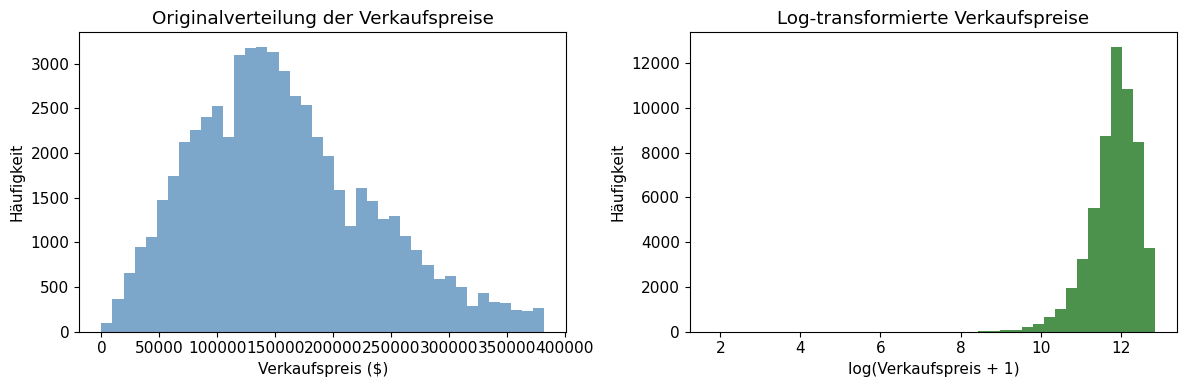

In [12]:
# Zielvariable – Log-Transformation zur Behandlung von Schiefe
df['Sale_price_log'] = np.log1p(df['Sale_price'])

original_skew = df['Sale_price'].skew()
log_skew = df['Sale_price_log'].skew()

print(f"Statistische Begründung für Log-Transformation:")
print(f"Skewness vor Transformation:  {original_skew:.2f} (stark rechtsschief)")
print(f"Skewness nach Transformation: {log_skew:.2f} (annähernd normalverteilt)")

# Visualisierung Original vs. Log
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(df['Sale_price'], bins=40, color='steelblue', alpha=0.7)
ax[0].set_title("Originalverteilung der Verkaufspreise")
ax[0].set_xlabel("Verkaufspreis ($)")
ax[0].set_ylabel("Häufigkeit")

ax[1].hist(df['Sale_price_log'], bins=40, color='darkgreen', alpha=0.7)
ax[1].set_title("Log-transformierte Verkaufspreise")
ax[1].set_xlabel("log(Verkaufspreis + 1)")
ax[1].set_ylabel("Häufigkeit")

plt.tight_layout()
plt.show()

# 4. EXPLORATIVE DATENANALYSE

## 4.1 Korrelationsanalyse

KORRELATIONSANALYSE & ZEITLICHE TRENDS

Top 10 Korrelationen mit Immobilienpreis:
Rooms             0.245246
Fbath             0.192376
FinishedSqft      0.172619
Rooms_per_Bath    0.171168
nbhd              0.157243
Sqft_per_Room     0.152351
Hbath             0.099984
Has_Basement      0.094997
Lotsize           0.094956
District          0.076872
Name: Sale_price_log, dtype: float64


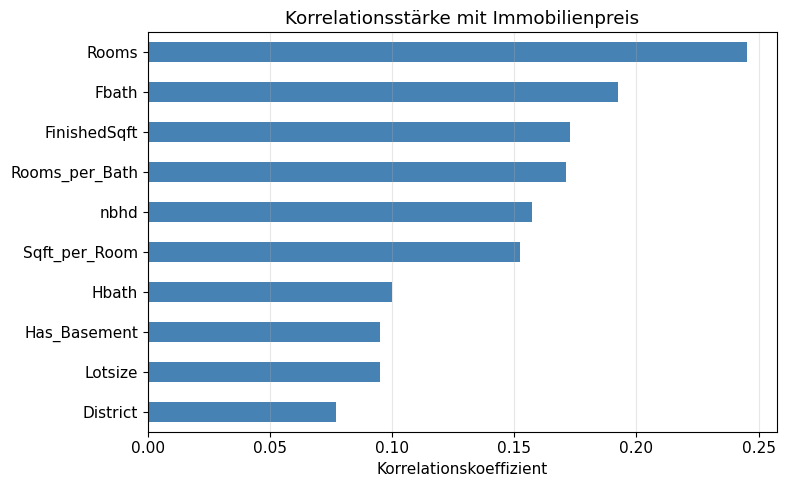

In [13]:
print("KORRELATIONSANALYSE & ZEITLICHE TRENDS")

# Finales Feature-Set für Modellierung definieren
features = [
    # Strukturelle Grundmerkmale
    'FinishedSqft', 'Building_Age', 'Rooms', 'Bdrms', 
    'Fbath', 'Hbath', 'Stories', 'Lotsize',
    
    # Abgeleitete Verhältnismetriken
    'Sqft_per_Room', 'Rooms_per_Bath', 'Bath_Ratio',
    
    # Boolesche Gebäudemerkmale
    'Has_Garage', 'Is_Remodeled', 'Has_Basement',
    
    # Geografische und administrative Merkmale
    'District', 'nbhd',
    
    # Kategorische Merkmale
    'PropType', 'Style', 'Season'
]

# Korrelationsanalyse nur mit numerischen Modell-Features
numerical_features_for_corr = [f for f in features if f in df.columns and df[f].dtype in ['int64', 'float64']] + ['Sale_price_log']
corr_matrix = df[numerical_features_for_corr].corr()
target_correlation = corr_matrix['Sale_price_log'].sort_values(ascending=False)

print("\nTop 10 Korrelationen mit Immobilienpreis:")
print(target_correlation.head(11)[1:])  # ohne Zielvariable selbst

# Visualisierung Top-Korrelationen
plt.figure(figsize=(8, 5))
target_correlation.head(11)[1:].plot(kind='barh', color='steelblue')
plt.gca().invert_yaxis()
plt.title("Korrelationsstärke mit Immobilienpreis")
plt.xlabel("Korrelationskoeffizient")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 4.2 Zeitliche Trendsanalyse

Analyse der zeitlichen Preisentwicklung...


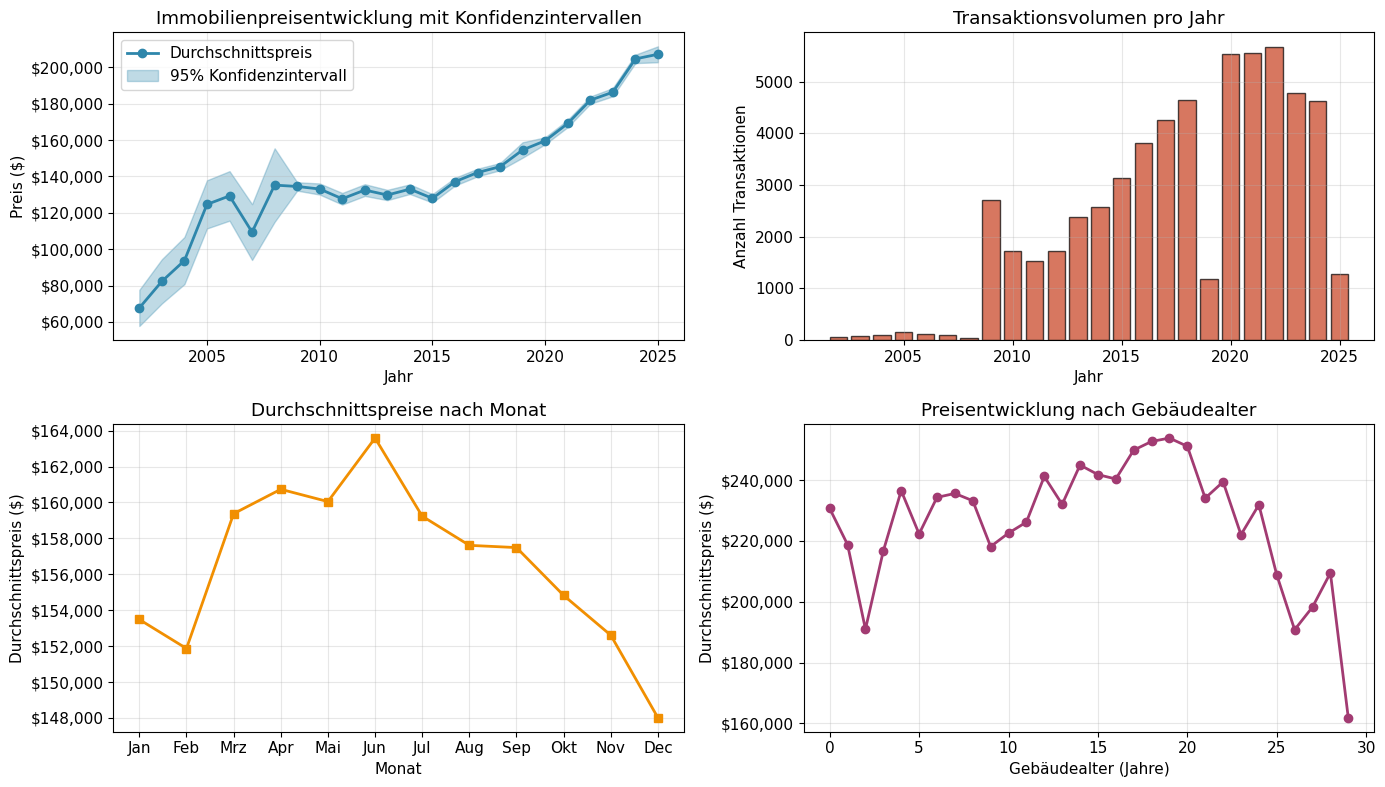


ZEITLICHE ANALYSE ZUSAMMENFASSUNG:
   • Analysezeitraum: 2002 - 2025
   • Preisanstieg: $67,686 → $207,197
   • Stärkster Monat: Jun ($163,588)
   • Schwächster Monat: Dec ($148,010)


In [14]:
# Zeitliche Preisentwicklung mit Konfidenzintervallen
print("Analyse der zeitlichen Preisentwicklung...")
yearly_stats = df.groupby('Sale_year')['Sale_price'].agg(['mean', 'std', 'count'])
yearly_stats = yearly_stats[yearly_stats['count'] > 10]  # Nur Jahre mit ausreichend Daten
yearly_stats['ci_lower'] = yearly_stats['mean'] - 1.96 * yearly_stats['std'] / np.sqrt(yearly_stats['count'])
yearly_stats['ci_upper'] = yearly_stats['mean'] + 1.96 * yearly_stats['std'] / np.sqrt(yearly_stats['count'])

plt.figure(figsize=(14, 8))

# Plot 1: Preisentwicklung mit CI
plt.subplot(2, 2, 1)
plt.plot(yearly_stats.index, yearly_stats['mean'], 
         marker='o', linewidth=2, color='#2E86AB', label='Durchschnittspreis')
plt.fill_between(yearly_stats.index, yearly_stats['ci_lower'], yearly_stats['ci_upper'], 
                 alpha=0.3, color='#2E86AB', label='95% Konfidenzintervall')
plt.title('Immobilienpreisentwicklung mit Konfidenzintervallen')
plt.xlabel('Jahr')
plt.ylabel('Preis ($)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Plot 2: Transaktionsvolumen
plt.subplot(2, 2, 2)
plt.bar(yearly_stats.index, yearly_stats['count'], 
        color='#C73E1D', alpha=0.7, edgecolor='black')
plt.title('Transaktionsvolumen pro Jahr')
plt.xlabel('Jahr')
plt.ylabel('Anzahl Transaktionen')
plt.grid(True, alpha=0.3)

# Plot 3: Saisonale Muster
monthly_prices = df.groupby('Sale_month')['Sale_price'].mean()
months = ['Jan', 'Feb', 'Mrz', 'Apr', 'Mai', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dec']

plt.subplot(2, 2, 3)
plt.plot(monthly_prices.index, monthly_prices.values, 
         marker='s', linewidth=2, color='#F18F01')
plt.xticks(monthly_prices.index, months)
plt.title('Durchschnittspreise nach Monat')
plt.xlabel('Monat')
plt.ylabel('Durchschnittspreis ($)')
plt.grid(True, alpha=0.3)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Plot 4: Preisentwicklung nach Gebäudealter
age_price = df.groupby('Building_Age')['Sale_price'].mean().head(30)  # Erste 30 Jahre

plt.subplot(2, 2, 4)
plt.plot(age_price.index, age_price.values, 
         marker='o', linewidth=2, color='#A23B72')
plt.title('Preisentwicklung nach Gebäudealter')
plt.xlabel('Gebäudealter (Jahre)')
plt.ylabel('Durchschnittspreis ($)')
plt.grid(True, alpha=0.3)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

# Zusammenfassung der zeitlichen Analyse
print(f"\nZEITLICHE ANALYSE ZUSAMMENFASSUNG:")
print(f"   • Analysezeitraum: {yearly_stats.index.min()} - {yearly_stats.index.max()}")
print(f"   • Preisanstieg: ${yearly_stats['mean'].iloc[0]:,.0f} → ${yearly_stats['mean'].iloc[-1]:,.0f}")
print(f"   • Stärkster Monat: {months[monthly_prices.idxmax()-1]} (${monthly_prices.max():,.0f})")
print(f"   • Schwächster Monat: {months[monthly_prices.idxmin()-1]} (${monthly_prices.min():,.0f})")

# 5. MODELLENTWICKLUNG

## 5.1 Datenaufteilung und Preprocessing-Pipeline

In [15]:
# Train Test Split für valide Evaluation
X = df[features].copy()
y = df['Sale_price_log']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.20, 
    random_state=RANDOM_STATE, 
    shuffle=True
)

print(f"Trainingsdaten: {X_train.shape[0]:,} Zeilen ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Testdaten:      {X_test.shape[0]:,} Zeilen ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"Features:       {X_train.shape[1]}")

# Identifikation der Spaltentypen
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

print(f"Numerische Features: {len(numeric_features)}")
print(f"Kategorische Features: {len(categorical_features)}")

# Definition der Preprocessing-Pipeline
preprocessor = ColumnTransformer([
    ('numeric', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_features),
    
    ('categorical', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), categorical_features)
])

print("Preprocessing-Pipeline erfolgreich definiert")

Trainingsdaten: 46,123 Zeilen (80.0%)
Testdaten:      11,531 Zeilen (20.0%)
Features:       19
Numerische Features: 16
Kategorische Features: 3
Preprocessing-Pipeline erfolgreich definiert


## 5.2 Baseline-Modelltraining

In [16]:
# Baseline-Modelle definieren und trainieren
models = {
    "Random Forest": RandomForestRegressor(
        random_state=RANDOM_STATE, 
        n_jobs=-1,
        verbose=0
    ),
    "Gradient Boosting": GradientBoostingRegressor(
        random_state=RANDOM_STATE
    ),
    "XGBoost": xgb.XGBRegressor(
        random_state=RANDOM_STATE, 
        n_jobs=-1, 
        verbosity=0
    ),
    "Ridge Regression": Ridge(random_state=RANDOM_STATE)
}

base_results = {}

for name, model in models.items():
    print(f"Training {name}")
    
    # Pipeline erstellen
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Training durchführen
    pipeline.fit(X_train, y_train)
    
    # Vorhersagen und Evaluation
    y_pred = pipeline.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    base_results[name] = {
        "r2": r2,
        "rmse": rmse, 
        "mae": mae,
        "pipeline": pipeline
    }
    
    print(f" {name:18} , R² = {r2:.3f} , RMSE = {rmse:.3f} , MAE = {mae:.3f}")

# Identifikation des besten Baseline-Modells
best_model_name = max(base_results, key=lambda k: base_results[k]['r2'])
best_baseline_pipeline = base_results[best_model_name]['pipeline']
best_baseline_score = base_results[best_model_name]['r2']

print(f"\nBESTES BASELINE-MODELL: {best_model_name}")
print(f" R² Score: {best_baseline_score:.3f}")

Training Random Forest
 Random Forest      , R² = 0.751 , RMSE = 0.301 , MAE = 0.204
Training Gradient Boosting
 Gradient Boosting  , R² = 0.614 , RMSE = 0.374 , MAE = 0.258
Training XGBoost
 XGBoost            , R² = 0.733 , RMSE = 0.312 , MAE = 0.211
Training Ridge Regression
 Ridge Regression   , R² = 0.401 , RMSE = 0.467 , MAE = 0.333

BESTES BASELINE-MODELL: Random Forest
 R² Score: 0.751


## 5.3 Hyperparameteroptimierung

In [17]:
# RandomizedSearchCV für effiziente Hyperparameteroptimierung
param_distributions = {
    "Random Forest": {
        'model__n_estimators': [50, 100, 150],
        'model__max_depth': [10, 15, 20, None],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['sqrt', 'log2', 0.5],
        'model__bootstrap': [True]
    }
}

if best_model_name in param_distributions:
    print("Starte Hyperparameteroptimierung mit RandomizedSearchCV")
    
    random_search = RandomizedSearchCV(
        estimator=best_baseline_pipeline,
        param_distributions=param_distributions[best_model_name],
        n_iter=20,  # 20 zufällige Kombinationen testen
        cv=3,
        scoring='r2',
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=1
    )
    
    start_time = datetime.now()
    random_search.fit(X_train, y_train)
    end_time = datetime.now()
    
    optimized_pipeline = random_search.best_estimator_
    best_cv_score = random_search.best_score_
    
    print(f"Optimierung abgeschlossen in {(end_time - start_time).total_seconds():.1f} Sekunden")
    print(f"Beste Parameter: {random_search.best_params_}")
    print(f"Bester Cross-Validation-Score: {best_cv_score:.3f}")
    
else:
    print("Verwende Baseline-Modell ohne Optimierung")
    optimized_pipeline = best_baseline_pipeline
    best_cv_score = base_results[best_model_name]['r2']

Starte Hyperparameteroptimierung mit RandomizedSearchCV
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Optimierung abgeschlossen in 57.6 Sekunden
Beste Parameter: {'model__n_estimators': 150, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': 0.5, 'model__max_depth': None, 'model__bootstrap': True}
Bester Cross-Validation-Score: 0.733


# 6. MODELLEVALUATION

## 6.1 Performance-Metriken

In [18]:
# Vorhersagen mit optimiertem Modell
y_pred = optimized_pipeline.predict(X_test)

# Metriken in log-Skala
final_r2 = r2_score(y_test, y_pred)
final_rmse_log = np.sqrt(mean_squared_error(y_test, y_pred))
final_mae_log = mean_absolute_error(y_test, y_pred)

# Rücktransformation in originale Einheiten
y_test_original = np.expm1(y_test)
y_pred_original = np.expm1(y_pred)

final_mae_original = mean_absolute_error(y_test_original, y_pred_original)
final_rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mean_price_original = y_test_original.mean()

print("PERFORMANCE IN LOG-SKALA:")
print(f"R²:    {final_r2:.3f}")
print(f"RMSE:  {final_rmse_log:.3f}")
print(f"MAE:   {final_mae_log:.3f}")

print("\nPERFORMANCE IN ORIGINALEN EINHEITEN:")
print(f"MAE:               ${final_mae_original:,.0f}")
print(f"RMSE:              ${final_rmse_original:,.0f}")
print(f"Durchschnittspreis: ${mean_price_original:,.0f}")
print(f"Relativer Fehler:   {(final_mae_original/mean_price_original)*100:.1f}%")

print("\nGESCHÄFTSRELEVANTE KPIS")

# Relative Fehleranalyse
absolute_errors = np.abs(y_pred_original - y_test_original)
relative_errors = absolute_errors / y_test_original

kpi_10_percent = (relative_errors < 0.10).mean() * 100
kpi_20_percent = (relative_errors < 0.20).mean() * 100

print(f"<10% Fehler: {kpi_10_percent:.1f}% der Vorhersagen")
print(f"<20% Fehler: {kpi_20_percent:.1f}% der Vorhersagen")

PERFORMANCE IN LOG-SKALA:
R²:    0.737
RMSE:  0.309
MAE:   0.204

PERFORMANCE IN ORIGINALEN EINHEITEN:
MAE:               $27,531
RMSE:              $37,897
Durchschnittspreis: $157,245
Relativer Fehler:   17.5%

GESCHÄFTSRELEVANTE KPIS
<10% Fehler: 37.0% der Vorhersagen
<20% Fehler: 63.8% der Vorhersagen


## 6.2 Bootstrap-Konfidenzintervalle

In [19]:
# Bootstrap-Konfidenzintervalle für MAE und R²
bootstrap_mae = []
bootstrap_r2 = []

print("Berechne Bootstrap-Konfidenzintervalle...")
for i in range(200):  # 200 Bootstrap-Iterationen
    indices = resample(range(len(y_test_original)))
    
    bootstrap_mae.append(mean_absolute_error(
        y_test_original.iloc[indices], 
        y_pred_original[indices]
    ))
    bootstrap_r2.append(r2_score(
        y_test.iloc[indices],
        y_pred[indices]
    ))

mae_ci = np.percentile(bootstrap_mae, [2.5, 97.5])
r2_ci = np.percentile(bootstrap_r2, [2.5, 97.5])

print(f"BOOTSTRAP-KONFIDENZINTERVALLE (95%):")
print(f"MAE:  (${mae_ci[0]:,.0f}, ${mae_ci[1]:,.0f})")
print(f"R²:   ({r2_ci[0]:.3f}, {r2_ci[1]:.3f})")

Berechne Bootstrap-Konfidenzintervalle...
BOOTSTRAP-KONFIDENZINTERVALLE (95%):
MAE:  ($27,093, $27,958)
R²:   (0.695, 0.764)


## 6.3 Cross-Validation für Generalisierungsfähigkeit

In [20]:
# Cross-Validation für robustere Performance-Schätzung
cv_scores = cross_val_score(optimized_pipeline, X_train, y_train, 
                           cv=5, scoring='r2')

print(f"CROSS-VALIDATION ERGEBNISSE (5-fold):")
print(f"R² Scores: {cv_scores}")
print(f"Durchschnittlicher R²: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

# Overfitting Check
train_r2 = optimized_pipeline.score(X_train, y_train)
test_r2 = optimized_pipeline.score(X_test, y_test)
performance_gap = train_r2 - test_r2

print(f"\nGENERALISIERUNGSANALYSE:")
print(f"Trainings-Genauigkeit (R²): {train_r2:.3f}")
print(f"Test-Genauigkeit (R²):      {test_r2:.3f}")
print(f"Generalisierungs-Gap:       {performance_gap:.3f}")

if performance_gap <= 0.05:
    generalization_rating = "Ausgezeichnet"
elif performance_gap <= 0.1:
    generalization_rating = "Gut"
else:
    generalization_rating = "Verbesserungsbedarf"

print(f"Generalisierungsbewertung:  {generalization_rating}")

CROSS-VALIDATION ERGEBNISSE (5-fold):
R² Scores: [0.75157241 0.74098106 0.73894017 0.71943422 0.74785833]
Durchschnittlicher R²: 0.740 (±0.011)

GENERALISIERUNGSANALYSE:
Trainings-Genauigkeit (R²): 0.936
Test-Genauigkeit (R²):      0.737
Generalisierungs-Gap:       0.199
Generalisierungsbewertung:  Verbesserungsbedarf


# 7. FEATURE IMPORTANCE ANALYSE

## 7.1 Permutation Importance

In [21]:
# Permutation Importance berechnen
perm_importance = permutation_importance(
    optimized_pipeline, 
    X_test, 
    y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring='neg_mean_absolute_error'
)

print(f"Länge der Importance Arrays: {len(perm_importance.importances_mean)}")

# Feature Namen aus der Pipeline extrahieren
try:
    feature_names = optimized_pipeline.named_steps['preprocessor'].get_feature_names_out()
    print(f"Anzahl Features aus Pipeline: {len(feature_names)}")
    
    # Feature Namen bereinigen für bessere Lesbarkeit
    clean_feature_names = []
    for name in feature_names:
        if name.startswith('numeric__'):
            clean_feature_names.append(name.replace('numeric__', ''))
        elif name.startswith('categorical__'):
            clean_name = name.replace('categorical__', '').replace('_', ': ')
            clean_feature_names.append(clean_name)
        else:
            clean_feature_names.append(name)
            
except Exception as e:
    print(f"Fehler beim Extrahieren der Feature-Namen: {e}")
    # Fallback: Verwende ursprüngliche Feature-Namen
    clean_feature_names = numeric_features + categorical_features
    print(f"Verwende ursprüngliche Feature-Namen: {len(clean_feature_names)}")

# Sicherstellen, dass die Längen übereinstimmen
min_length = min(len(clean_feature_names), len(perm_importance.importances_mean))
clean_feature_names = clean_feature_names[:min_length]
importance_means = perm_importance.importances_mean[:min_length]
importance_stds = perm_importance.importances_std[:min_length]

print(f"Finale Feature-Count: {len(clean_feature_names)} Features, {len(importance_means)} Importance-Werte")

# Feature Importance DataFrame erstellen
feature_importance_df = pd.DataFrame({
    'feature': clean_feature_names,
    'importance_mean': importance_means,
    'importance_std': importance_stds
}).sort_values('importance_mean', ascending=False).head(15)

print("\nTOP 15 FEATURE IMPORTANCES:")
for i, row in feature_importance_df.iterrows():
    print(f"   {i+1:2d}. {row['feature']:35} {row['importance_mean']:.4f} ± {row['importance_std']:.4f}")

# Business Interpretation der Top-Features
print("\n" + "="*60)
print("BUSINESS INTERPRETATION DER TOP-FEATURES")
print("="*60)

feature_interpretations = {
    'nbhd': "Nachbarschaft - Mikrolage als wichtigster Preisfaktor",
    'District': "Stadtbezirk - administrative Lageeinteilung", 
    'FinishedSqft': "Wohnfläche - grundlegender Werttreiber",
    'Rooms': "Zimmeranzahl - Grundrisseffekt",
    'Building_Age': "Gebäudealter - Wertminderung über Zeit",
    'Lotsize': "Grundstücksgröße - Flächenwert",
    'Rooms_per_Bath': "Badausstattung - Komfortfaktor",
    'Fbath': "Vollbäder - Ausstattungsqualität",
    'Sqft_per_Room': "Raumgröße - Luxusindikator",
    'PropType: Condominium': "Eigentumswohnung - Eigentumsform",
    'Bath_Ratio': "Verhältnis Vollbäder zu Halbbädern",
    'Has_Basement': "Keller vorhanden - zusätzlicher Raum",
    'Has_Garage': "Garage vorhanden - Komfortmerkmal",
    'Is_Remodeled': "Gebäude saniert - Wertsteigerung"
}

for i, row in feature_importance_df.head(8).iterrows():
    feature = row['feature']
    importance = row['importance_mean']
    interpretation = feature_interpretations.get(feature, "Weiterer Einflussfaktor")
    print(f"#{i+1}: {feature:25} {importance:.3f} - {interpretation}")

Länge der Importance Arrays: 19
Anzahl Features aus Pipeline: 162
Finale Feature-Count: 19 Features, 19 Importance-Werte

TOP 15 FEATURE IMPORTANCES:
   16. nbhd                                0.2025 ± 0.0018
    3. Rooms                               0.0776 ± 0.0013
   15. District                            0.0769 ± 0.0011
    1. FinishedSqft                        0.0679 ± 0.0011
    2. Building_Age                        0.0437 ± 0.0006
    8. Lotsize                             0.0324 ± 0.0010
   18. PropType: Condominium               0.0153 ± 0.0003
    9. Sqft_per_Room                       0.0135 ± 0.0003
   17. PropType: Commercial                0.0109 ± 0.0004
   10. Rooms_per_Bath                      0.0104 ± 0.0006
    5. Fbath                               0.0073 ± 0.0003
   12. Has_Garage                          0.0043 ± 0.0002
    4. Bdrms                               0.0036 ± 0.0002
   19. PropType: Exempt                    0.0014 ± 0.0002
    7. Stories          

## 7.2 Feature Importance Visualisierung

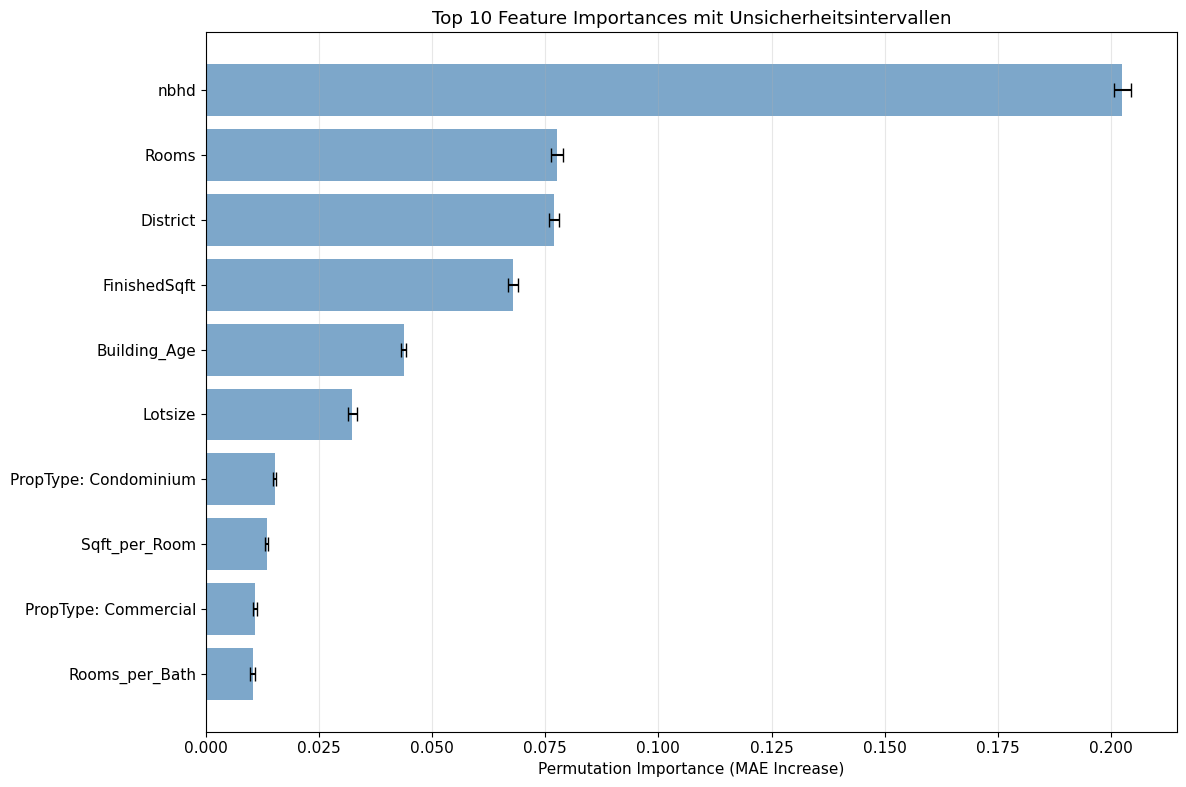

In [22]:
# Visualisierung der Top 10 Feature Importances
plt.figure(figsize=(12, 8))
top_features_viz = feature_importance_df.head(10)

plt.barh(range(len(top_features_viz)), 
         top_features_viz['importance_mean'],
         xerr=top_features_viz['importance_std'],
         alpha=0.7, capsize=5, color='steelblue')

plt.yticks(range(len(top_features_viz)), top_features_viz['feature'])
plt.gca().invert_yaxis()
plt.xlabel('Permutation Importance (MAE Increase)')
plt.title('Top 10 Feature Importances mit Unsicherheitsintervallen')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# 8. MODELLDIAGNOSTIK

## 8.1 Residuenanalyse

RESIDUENANALYSE:
Residuen-Mittelwert: 0.0037 (sollte nahe 0 sein)
Residuen-Standardabweichung: 0.3090
Residuen-Schiefe: -4.3447
Beurteilung Mittelwert: ✓ Sehr gut - Mittelwert nahe 0
Beurteilung Schiefe: ⚠️ Verbesserungsbedarf - starke Schiefe


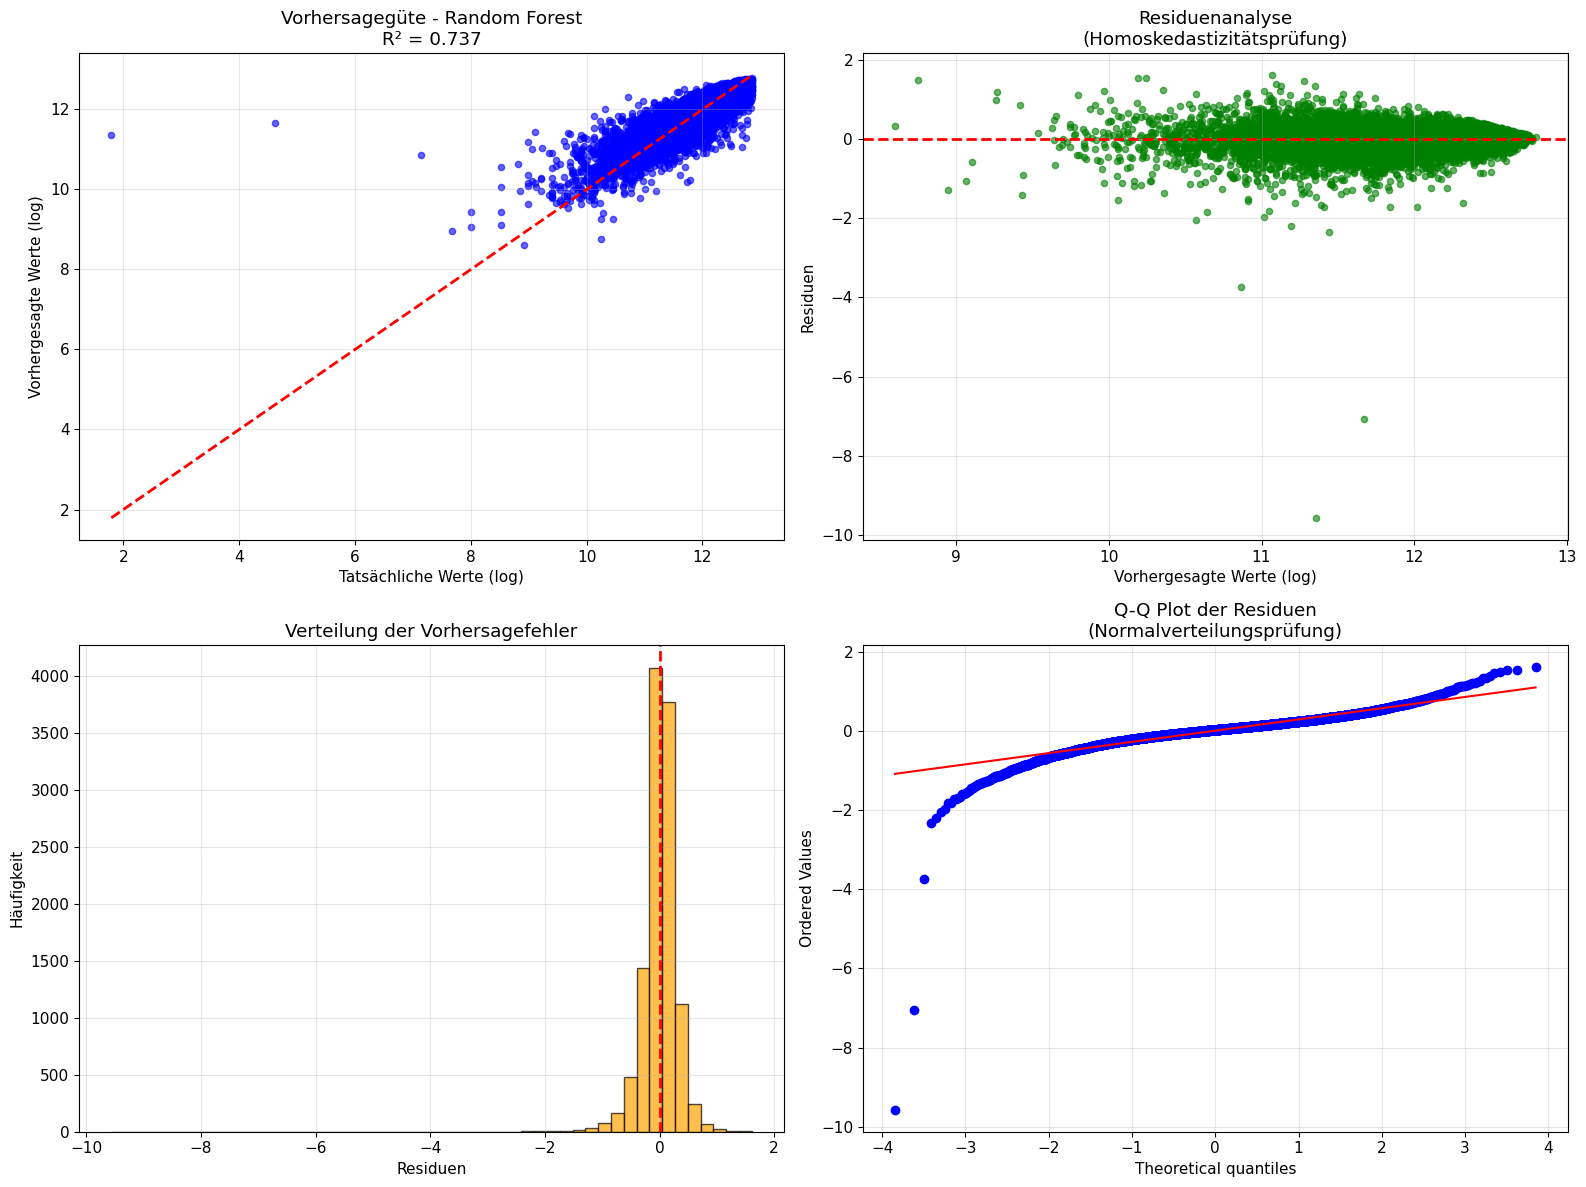

In [23]:
# Residuenanalyse
residuals = y_test - y_pred
residuals_skew = pd.Series(residuals).skew()

print("RESIDUENANALYSE:")
print(f"Residuen-Mittelwert: {residuals.mean():.4f} (sollte nahe 0 sein)")
print(f"Residuen-Standardabweichung: {residuals.std():.4f}")
print(f"Residuen-Schiefe: {residuals_skew:.4f}")

# Beurteilung der Residuen
if abs(residuals.mean()) < 0.01:
    mean_assessment = "✓ Sehr gut - Mittelwert nahe 0"
elif abs(residuals.mean()) < 0.05:
    mean_assessment = "○ Gut - Mittelwert akzeptabel"
else:
    mean_assessment = "⚠️ Verbesserungsbedarf - Mittelwert zu hoch"

if abs(residuals_skew) < 0.5:
    skew_assessment = "✓ Sehr gut - annähernd normalverteilt"
elif abs(residuals_skew) < 1.0:
    skew_assessment = "○ Gut - leichte Schiefe"
else:
    skew_assessment = "⚠️ Verbesserungsbedarf - starke Schiefe"

print(f"Beurteilung Mittelwert: {mean_assessment}")
print(f"Beurteilung Schiefe: {skew_assessment}")

# Diagnostische Visualisierungen
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Vorhersagegüte (log-Skala)
axes[0,0].scatter(y_test, y_pred, alpha=0.6, s=20, color='blue')
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
axes[0,0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[0,0].set_xlabel('Tatsächliche Werte (log)')
axes[0,0].set_ylabel('Vorhergesagte Werte (log)')
axes[0,0].set_title(f'Vorhersagegüte - {best_model_name}\nR² = {final_r2:.3f}')
axes[0,0].grid(alpha=0.3)

# Plot 2: Residuen vs. Vorhersagen
axes[0,1].scatter(y_pred, residuals, alpha=0.6, s=20, color='green')
axes[0,1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0,1].set_xlabel('Vorhergesagte Werte (log)')
axes[0,1].set_ylabel('Residuen')
axes[0,1].set_title('Residuenanalyse\n(Homoskedastizitätsprüfung)')
axes[0,1].grid(alpha=0.3)

# Plot 3: Histogramm der Residuen
axes[1,0].hist(residuals, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1,0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1,0].set_xlabel('Residuen')
axes[1,0].set_ylabel('Häufigkeit')
axes[1,0].set_title('Verteilung der Vorhersagefehler')
axes[1,0].grid(alpha=0.3)

# Plot 4: Q-Q Plot für Normalverteilungsprüfung
stats.probplot(residuals, dist="norm", plot=axes[1,1])
axes[1,1].set_title('Q-Q Plot der Residuen\n(Normalverteilungsprüfung)')
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 9. MODELLSPEICHERUNG UND METADATEN

In [24]:
# Modelle und Preprocessor speichern
joblib.dump(optimized_pipeline, "../output/final_model.pkl")
joblib.dump(preprocessor, "../output/preprocessor.pkl")

# Umfassende Metadaten und Metriken speichern
metadata = {
    "project_info": {
        "project_name": "Immobilienpreisvorhersage Milwaukee",
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "random_state": RANDOM_STATE
    },
    "data_info": {
        "initial_data_shape": [initial_rows, dataset.shape[1]],
        "final_data_shape": list(X.shape),
        "data_quality_actions": {
            "rows_removed_due_to_missing_prices": initial_rows - len(df[df['Sale_price'].notna() & (df['Sale_price'] > 0)]),
            "rows_removed_due_to_outliers": "siehe Outlier Report",
            "columns_removed_due_to_high_missing": cols_to_drop
        },
        "train_test_split": {
            "train_size": X_train.shape[0],
            "test_size": X_test.shape[0],
            "split_ratio": "80/20"
        }
    },
    "model_info": {
        "best_baseline_model": best_model_name,
        "final_model_type": type(optimized_pipeline.named_steps['model']).__name__,
        "optimization_method": "RandomizedSearchCV",
        "best_parameters": random_search.best_params_ if 'random_search' in locals() else "Baseline parameters"
    },
    "performance_metrics": {
        "log_scale": {
            "r2": float(final_r2),
            "rmse": float(final_rmse_log),
            "mae": float(final_mae_log)
        },
        "original_scale": {
            "mae": float(final_mae_original),
            "rmse": float(final_rmse_original),
            "mean_price": float(mean_price_original),
            "relative_error_percentage": float((final_mae_original/mean_price_original)*100)
        },
        "business_kpis": {
            "predictions_under_10pct_error": float(kpi_10_percent),
            "predictions_under_20pct_error": float(kpi_20_percent)
        },
        "bootstrap_confidence_intervals": {
            "mae_95_ci": [float(mae_ci[0]), float(mae_ci[1])],
            "r2_95_ci": [float(r2_ci[0]), float(r2_ci[1])]
        },
        "cross_validation": {
            "cv_scores": cv_scores.tolist(),
            "cv_mean": float(cv_scores.mean()),
            "cv_std": float(cv_scores.std())
        },
        "generalization": {
            "train_r2": float(train_r2),
            "test_r2": float(test_r2),
            "performance_gap": float(performance_gap),
            "generalization_rating": generalization_rating
        }
    },
    "feature_analysis": {
        "top_10_features": feature_importance_df.head(10)[['feature', 'importance_mean', 'importance_std']].to_dict('records'),
        "total_features_used": len(features)
    }
}

# Speicherung der Metadaten
with open("../output/metrics.json", "w", encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

joblib.dump(metadata, "../output/model_metadata.pkl")

print("Modell und Metadaten erfolgreich gespeichert:")
print("• final_model.pkl")
print("• preprocessor.pkl") 
print("• metrics.json")
print("• model_metadata.pkl")

Modell und Metadaten erfolgreich gespeichert:
• final_model.pkl
• preprocessor.pkl
• metrics.json
• model_metadata.pkl


## 10. ZUSAMMENFASSUNG UND EMPFEHLUNGEN

In [26]:
# Zusammenfassung der wichtigsten Ergebnisse 
print(f"\nMODELLPERFORMANCE:")
print(f"Bestes Modell:               {best_model_name}")
print(f"Vorhersagegenauigkeit (R²):  {final_r2:.3f}")
print(f"Durchschnittlicher Fehler:   ${final_mae_original:,.0f}")
print(f"Relative Genauigkeit:        {kpi_10_percent:.1f}% <10% Fehler, {kpi_20_percent:.1f}% <20% Fehler")

print(f"\nMODELLQUALITÄT:")
print(f"Generalisierung:             {generalization_rating} (Gap: {performance_gap:.3f})")
print(f"Cross-Validation:            {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
print(f"Wichtigstes Feature:         {feature_importance_df.iloc[0]['feature']}")
print(f"Bootstrap-Konfidenz:         R² in ({r2_ci[0]:.3f}, {r2_ci[1]:.3f})")

print(f"\nPRAXISEMPFEHLUNGEN:")
print(f"Das Modell eignet sich für automatisierte Preisvorhersagen")
print(f"Besonders geeignet für Standard- und Mittelklasse-Immobilien")
print(f"Regelmäßige Neukalibrierung alle 6-12 Monate empfohlen")
print(f"Monitoring auf Data Drift implementieren")
print(f"Top-Features für Fokus bei Immobilienbewertung nutzen")

print(f"\nLIMITATIONEN UND AUSBLICK:")
print(f"Premium- und Sonderimmobilien schwer modellierbar")
print(f"Externe Marktfaktoren (Zinsen, Wirtschaftslage) nicht berücksichtigt")
print(f"Regionale Besonderheiten möglicherweise nicht vollständig erfasst")
print(f"Modell benötigt regelmäßige Updates mit neuen Transaktionsdaten")


MODELLPERFORMANCE:
Bestes Modell:               Random Forest
Vorhersagegenauigkeit (R²):  0.737
Durchschnittlicher Fehler:   $27,531
Relative Genauigkeit:        37.0% <10% Fehler, 63.8% <20% Fehler

MODELLQUALITÄT:
Generalisierung:             Verbesserungsbedarf (Gap: 0.199)
Cross-Validation:            0.740 ± 0.011
Wichtigstes Feature:         nbhd
Bootstrap-Konfidenz:         R² in (0.695, 0.764)

PRAXISEMPFEHLUNGEN:
Das Modell eignet sich für automatisierte Preisvorhersagen
Besonders geeignet für Standard- und Mittelklasse-Immobilien
Regelmäßige Neukalibrierung alle 6-12 Monate empfohlen
Monitoring auf Data Drift implementieren
Top-Features für Fokus bei Immobilienbewertung nutzen

LIMITATIONEN UND AUSBLICK:
Premium- und Sonderimmobilien schwer modellierbar
Externe Marktfaktoren (Zinsen, Wirtschaftslage) nicht berücksichtigt
Regionale Besonderheiten möglicherweise nicht vollständig erfasst
Modell benötigt regelmäßige Updates mit neuen Transaktionsdaten
